In [1]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.71  Python-3.10.16 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
Setup complete  (16 CPUs, 31.7 GB RAM, 404.3/933.7 GB disk)


In [2]:
from ultralytics import YOLO

from IPython.display import display, Image

In [3]:
API_KEY = 'LUfenSmTeCzCw24QScjY'

In [4]:
import requests
requests.packages.urllib3.disable_warnings()

import roboflow
rf = roboflow.Roboflow(api_key=API_KEY)

project = rf.workspace("powerlineobstructiondetection").project("obstructions-only")
dataset = project.version(1).download("yolo11")

loading Roboflow workspace...
loading Roboflow project...

Version export complete for yolo11 format



Extracting Dataset Version Zip to Obstructions-Only-1 in yolo11:: 100%|████████████| 174/174 [00:00<00:00, 1636.32it/s]


In [6]:
model = YOLO('/YOLO11/yolo11n.pt')

model.train(
    data='/content/Obstructions-Only-1/data.yaml',
    epochs=50,
    imgsz=416,
    batch=4,
    device = 'gpu',
    amp=True,
)

100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 22.2MB/s]


Ultralytics 8.3.71  Python-3.10.16 torch-2.6.0+cpu 


ValueError: Invalid CUDA 'device=gpu' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [8]:
import cv2
import glob
import os

image_folder = "/content/Obstructions-Only-1/test/images/"
output_folder = "/content/Annotated/"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Class-to-color mapping
class_colors = {
    5: (0, 255, 255),       # Yellow
    7: (0, 255, 0),         # Green
    0: (0, 0, 255)    # Red
}

class_names= {
    5: 'poles',
    7: 'wires',
    0: 'obstruction'
}

# Get all image file paths
image_paths = glob.glob(f"{image_folder}*.jpg")  # Adjust the file extension if needed

# Iterate through each image
for path in image_paths:
    # Read the image
    image = cv2.imread(path)
    image = cv2.resize(image, (640, 640))  # Resize to match model requirements

    results = model.predict(path)[0]

    # Get bounding boxes, class IDs, and confidence scores
    boxes = results.boxes.xyxy.cpu().numpy()  # Bounding box coordinates
    class_ids = results.boxes.cls.cpu().numpy()  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    class_names = results.names  # Dictionary of class names
    # Draw bounding boxes
    for box, class_id, conf in zip(boxes, class_ids, confidences):
        x1, y1, x2, y2 = map(int, box)
        class_name = class_names[class_id]
        box_color = class_colors.get(class_id, (255, 255, 255))  # Default to white if class not mapped

        # Draw rectangle (BGR color for OpenCV)
        cv2.rectangle(image, (x1, y1), (x2, y2), box_color, 2)

        # Add text label (inside the box, smaller font)
        label = f"{class_name} ({conf*100:.1f}%)"
        cv2.putText(image, label,
                    (x1 + 5, y1 + 20),  # Slight padding from the top-left corner of the box
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)  # Smaller font, thinner text

    # Save the annotated image
    output_path = os.path.join(output_folder, os.path.basename(path))
    cv2.imwrite(output_path, image)

print(f"Annotated images saved to: {output_folder}")


image 1/1 /content/Obstructions-Only-1/test/images/57_00186_jpg.rf.a1fdc77e9ed4ba5e92865583fe84406b.jpg: 416x416 (no detections), 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/Obstructions-Only-1/test/images/kite-gets-stuck-power-line-260nw-2356431697_webp.rf.6ea07403480d8b7f754daf8882d17fcd.jpg: 416x416 2 obstructions, 9.8ms
Speed: 1.5ms preprocess, 9.8ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/Obstructions-Only-1/test/images/105_5430_jpg.rf.a15a034cbc787cd31f14bd298bca171e.jpg: 416x416 (no detections), 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/Obstructions-Only-1/test/images/download-9-_jpg.rf.2ab007900198a33618475a64d485caed.jpg: 416x416 (no detections), 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/Obstructio

In [9]:
metrics = model.val()  # This will evaluate the model on the validation dataset

# Print the results
print("Validation Metrics:")

# Access results_dict to get a dictionary of all metrics
results = metrics.results_dict

# Print all metrics
for metric, value in results.items():
    print(f"{metric}: {value}")

Ultralytics 8.3.71 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:gpu (Tesla T4, 15095MiB)


val: Scanning /content/Obstructions-Only-1/valid/labels.cache... 8 images, 3 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


                   all          8          5       0.74      0.576      0.581      0.311
Speed: 0.5ms preprocess, 17.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train2
Validation Metrics:
metrics/precision(B): 0.7401879997722118
metrics/recall(B): 0.5764511994533084
metrics/mAP50(B): 0.5810323886639676
metrics/mAP50-95(B): 0.3107198815950131
fitness: 0.33775113230190856


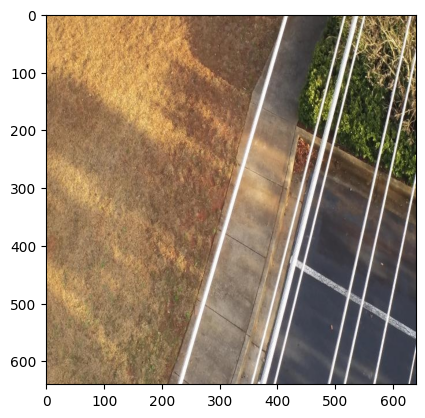

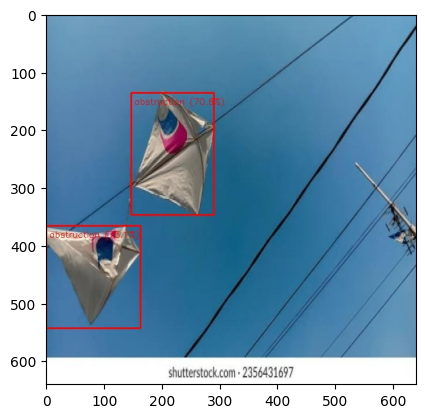

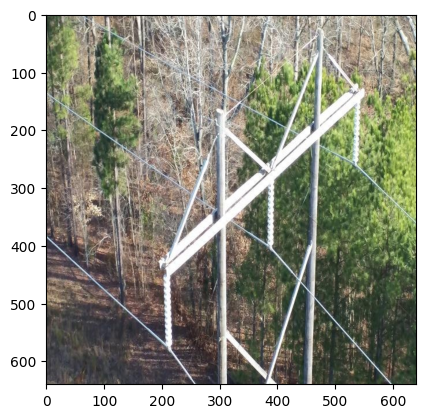

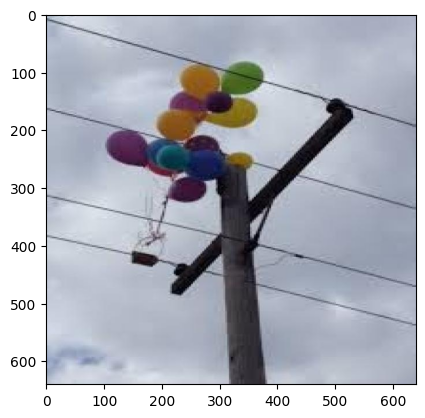

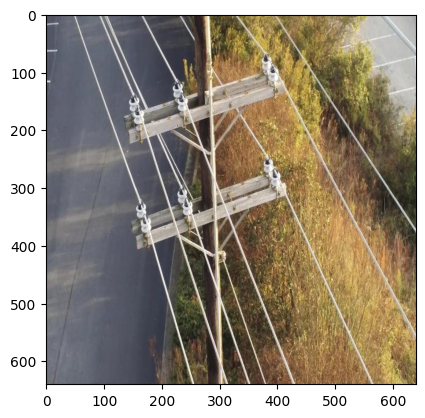

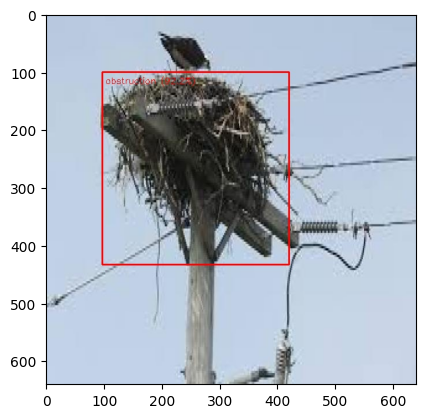

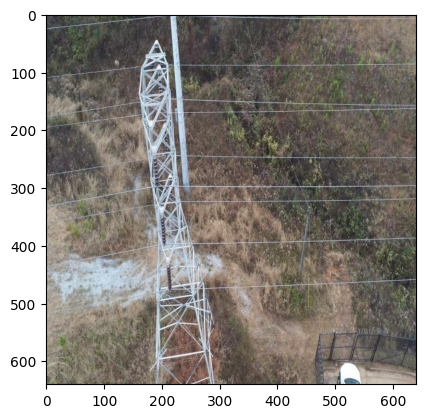

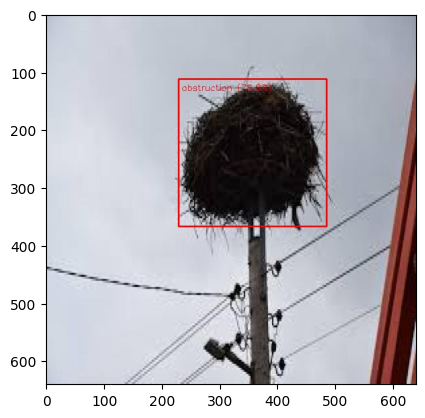

In [10]:
import matplotlib.pyplot as plt

image_paths = glob.glob(f"{'/content/Annotated/'}*.jpg")  # Adjust the file extension if needed

# Iterate through each image
for path in image_paths:
    image_pixels = plt.imread(path)
    plt.imshow(image_pixels)
    plt.show()